## Fine-tuning ViT

### Data preprocessing

In [20]:
import numpy as np
from datasets import load_dataset
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import CenterCrop,Compose,Normalize,RandomHorizontalFlip,RandomResizedCrop,Resize,ToTensor
from torch.utils.data import DataLoader
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
#%pip install transformers==4.37.2
#%pip install accelerate==0.28.0
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
def prepare_dataset():
    train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
    splits = train_ds.train_test_split(test_size=0.2, seed=42)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = prepare_dataset()
print(train_ds)
print(val_ds)
print(test_ds)

train_ds.features

Dataset({
    features: ['img', 'label'],
    num_rows: 4000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})


{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

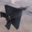

In [22]:
# take train_data of index 0 and plot image and corresponding label
train_ds[0]['label']
id2label = {i: name for i, name in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
train_ds[0]['img']

In [23]:
label_name = id2label[train_ds[0]['label']]
print(label_name)

airplane


In [24]:
# load the processor to preprocess data
ViTprocessor = ViTImageProcessor.from_pretrained('facebook/deit-tiny-patch16-224')


In [25]:
image_mean, image_std = ViTprocessor.image_mean, ViTprocessor.image_std
size = ViTprocessor.size["height"]

normalize = Normalize(ViTprocessor.image_mean, ViTprocessor.image_std)

_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [26]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [27]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

### Model



In [28]:
ViTmodel = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224', 
                                                     num_labels=10,
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    ignore_mismatched_sizes=True)

## posso usare anche facebook/deit-small-patch16-224 che ha molti più parametri (più training time)

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    logging_dir='logs',
    remove_unused_columns=False,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(
        eval_accuracy=accuracy_score(labels, predictions),
        eval_f1_score=f1_score(labels, predictions, average="weighted")
    )

trainer = Trainer(
    model=ViTmodel,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

#model already trained and saved correctly
#trainer.train()


/Users/gallo/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [30]:
trainer = Trainer(
    model=ViTForImageClassification.from_pretrained("test-cifar-10/checkpoint-2500"),
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=ViTprocessor,
)

results = trainer.evaluate()
print("\nEvaluation Metrics")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"F1 Score: {results['eval_f1_score']:.4f}")
print(f"Loss: {results['eval_loss']:.4f}")

  0%|          | 0/63 [00:00<?, ?it/s]


Evaluation Metrics
Accuracy: 0.9270
F1 Score: 0.9269
Loss: 0.2611


In [31]:
outputs = trainer.predict(test_ds)
for metric, value in outputs.metrics.items():
    print(f"{metric}: {value:.4f}")


  0%|          | 0/125 [00:00<?, ?it/s]

test_loss: 0.2610
test_eval_accuracy: 0.9265
test_eval_f1_score: 0.9264
test_runtime: 10.4357
test_samples_per_second: 191.6500
test_steps_per_second: 11.9780


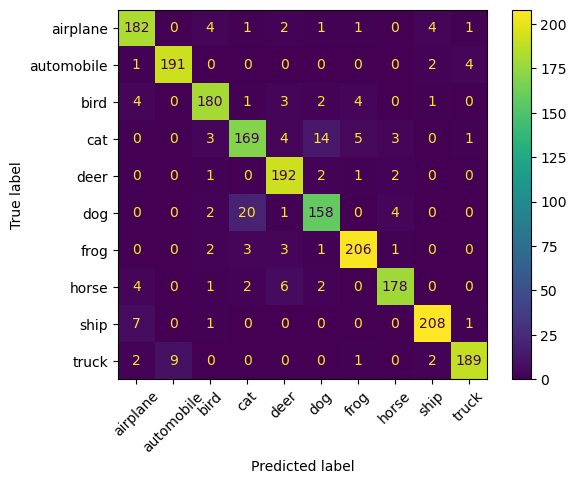

In [32]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### Test the explainability of the model with new images

In [33]:
ID2CLS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [34]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# compute the probability of all the classes to be assigned to a test image, thourgh softmax
def print_top_classes(predictions):
    probs = torch.softmax(predictions, dim=-1)
    class_indices = predictions.data.topk(10, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(ID2CLS[cls_idx])
        if len(ID2CLS[cls_idx]) > max_str_len:
            max_str_len = len(ID2CLS[cls_idx])
    print('Probability on all the classes:')
    for cls_idx in class_indices:
        output_string = '\t{}'.format(ID2CLS[cls_idx])
        output_string += ' ' * (max_str_len - len(ID2CLS[cls_idx])) + '\t'
        output_string += 'prob = {:.1f}%'.format(100 * probs[0, cls_idx])
        print(output_string)

### Attention rollout

We see which part or which feature of the image most influences the model prediction

In [35]:
def attention_rollout(attentions, discard_ratio):
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    for attn in attentions:
        attn_heads_fused = attn[0].mean(0)
        
        if discard_ratio > 0:
            flat = attn_heads_fused.view(-1)
            _, indices = flat.topk(int(flat.size(0) * discard_ratio), largest=False)
            flat[indices] = 0
            attn_heads_fused = flat.view(attn_heads_fused.size())

        attn_heads_fused += torch.eye(attn_heads_fused.size(0)).to(attn_heads_fused.device)
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn_heads_fused, result)
    mask = result[0, 1:]
    return mask

In [36]:
def generate_visualization(pil_image, outputs, logits):

    attentions = outputs.attentions
    probs = torch.softmax(logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()
    label = ID2CLS.get(pred_class, str(pred_class))

    mask = attention_rollout(attentions, discard_ratio = 0.4)
    num_patches = mask.shape[0]
    size = int(num_patches ** 0.5)
    mask = mask.reshape(1, 1, size, size)

    cam = torch.nn.functional.interpolate(mask, scale_factor=16, mode='bilinear').squeeze().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    image_np = np.array(pil_image.resize((224, 224))).astype(np.float32) / 255.0
    cam_overlay = show_cam_on_image(image_np, cam)

    return cam_overlay, label


Predicted class (with heatmap): deer


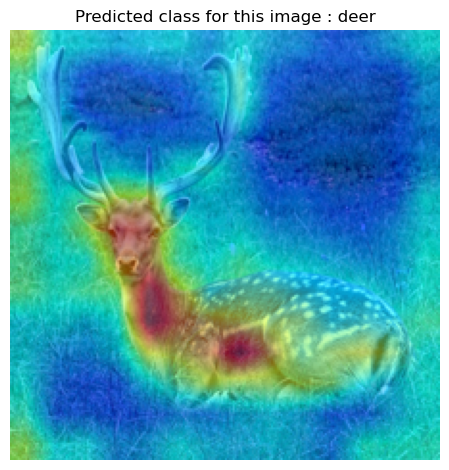

Probability on all the classes:
	deer      	prob = 93.0%
	bird      	prob = 2.0%
	dog       	prob = 1.2%
	ship      	prob = 0.8%
	cat       	prob = 0.8%
	horse     	prob = 0.6%
	frog      	prob = 0.6%
	airplane  	prob = 0.5%
	truck     	prob = 0.4%
	automobile	prob = 0.3%


In [41]:
model_name = 'test-cifar-10/checkpoint-2500'
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)
processor = ViTImageProcessor.from_pretrained(model_name)
model.eval()

image = Image.open("test_img/deer2.png")
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits


vis, label = generate_visualization(image, outputs, predictions)

print(f"\nPredicted class (with heatmap): {label}")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class for this image : {label}")
plt.axis("off")
plt.tight_layout()
plt.show()
print_top_classes(predictions)